# Aperiodic electrophysiological activity tracks spiking statistics between behavioral states
Sawyer Figueroa, Michael Preston, Bradley Voytek

# SfN 2023, Poster Panel 
This notebook reproduces the figures from poster panel 5. Panel 5 investigates the relationship between spike-synchrony and aperiodic LFP activity. Spiking and spectral parameters are quantified with high temporal resolution in order to elucidate dynamic changes on the timescale of miliseconds. 

#

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

## Set-up

### set paths

In [101]:
# set paths
PROJECT_PATH = "G:/Shared drives/visual_encoding" # shared results directory
MANIFEST_PATH = 'D:/datasets/allen_vc' # path to manifest file and local dataset

### imports

In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# Imports
import pandas as pd
import numpy as np
import neo
import quantities as pq
from elephant.statistics import instantaneous_rate
from elephant import kernels
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sys
import os
import contextlib
from time import time as timer

In [104]:
# custom imports
import sys
sys.path.append('../../')

from allen_vc.plots import plot_time_resolved_params, error_scatter_plot, plot_regression_line
from allen_vc.utils import print_time_elapsed
from allen_vc.analysis import compute_pyspike_metrics
from allen_vc.stats import mixedLM

print("Packages Imported")

Packages Imported


### settings

In [105]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')
colors = ['orangered', 'darkcyan']
# COLORS = ["#7570b3", "#3FAA96", "#F39943"]

### functions

In [106]:

from matplotlib.pyplot import xlabel


def plot_linregress(df, x_var, y_var, group=None, multireg=False, singlereg=False, legend=True, title='', 
                    print_stats=False, fname_out=None, show=False, close=False, scatter_alpha=0.6, colors=None,
                    x_label=None, y_label=None):
    """
    Calculate and plot the linear regression of two columns in a dataframe.

    Parameters
    ----------
    x_var : str
        column with x-values of dataset
    y_var : str
        column with y-values of dataset
    group: str, optional
        column to color/section data by.
    multireg: bool, optional
        whether or not to plot regression lines for each group
    singlereg: bool, optional
        whether or not to plot a single regression line for all data
    legend: bool, optional
        whether or not to include a legend
    title: str, optional
        title of the figure
    print_stats: bool, optional
        whether or not to print regression statistics
    fname_out : str, optional
        Filename of the output figure
    show : bool, optional
        Whether to show the figure or not
    close : bool, optional
        Whether to close the figure or not
    scatter_alpha : float, optional
        Alpha value for scatter points
    colors : list, optional
        List of colors to use for each group

    Returns
    -------
    None
    """
    
    # create figure
    fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
    fig.patch.set_facecolor('white') # set background color to white for text legibility
    markers = ['.', 'v']
    colors = ['C0', 'C1', 'C2', 'C3'] if colors is None else colors
    
    # plot data
    c = 0
    for r, region in enumerate(df['brain_structure'].unique()):
        region_df = df[df['brain_structure'] == region]

        if group is not None:
            groups = region_df[group].unique()
            for i, g in enumerate(groups):
                gdf = region_df[region_df[group] == g]
                ax.scatter(gdf[x_var], gdf[y_var], label=region + ' ' + g, 
                    alpha=scatter_alpha, marker=markers[r], color=colors[c])

                if multireg:
                    # run regression and plot results
                    if print_stats:
                        plot_regression_line(gdf[x_var], gdf[y_var], ax=ax, 
                            text_height=0.9-r*0.4-i*0.2, label=region + ' ' + g, color=colors[c])
                    else:
                        plot_regression_line(gdf[x_var], gdf[y_var], ax=ax, 
                            print_stats=False, color=colors[c])
                    c += 1

            if singlereg:
                if print_stats:
                    plot_regression_line(region_df[x_var], region_df[y_var], ax=ax, 
                            text_height=0.9-r*0.4, label=region, color='black')
                else:
                    plot_regression_line(region_df[x_var], region_df[y_var], ax=ax, 
                            print_stats=False, color='black')

        else:
            ax.scatter(region_df[x_var], region_df[y_var], label=region, 
                alpha=scatter_alpha, color=colors[c])

            # run regression and plot results
            if print_stats:
                plot_regression_line(region_df[x_var], region_df[y_var], ax=ax, 
                    text_height=0.9-r*0.2, label=region, color=colors[c])
            else:
                plot_regression_line(region_df[x_var], region_df[y_var], ax=ax, 
                    print_stats=False, color=colors[c])
            c += 1


    # label figure
    if legend:
        ax.legend(loc='lower right')
    plt.title(title)
    if xlabel is None:
        plt.xlabel(x_var.replace('_',' '))
    else:
        plt.xlabel(x_label)
    if y_label is None:
        plt.ylabel(y_var.replace('_',' '))
    else:
        plt.ylabel(y_label)
                
    # save/show figure
    if not fname_out is None:
        fig.savefig(fname_out)
    if show:
        plt.show()
    if close:
        plt.close()
        


### load data

In [107]:
# concatenate param data
dfs = []
for file in os.listdir(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session'):
    dfs.append(pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session/{file}'))

all_chans = pd.concat(dfs)

FYI: The above results can typically be imported directly '<project_path>/lfp_data/params/tfr/<stim_code>/lfp_params.csv'

## Main

### Compute time-resolved spike and pupil metrics

In [108]:
# # median across channels
# params = all_chans.groupby(['session', 'epoch_idx', 'window_idx']).median().drop(['chan_idx'], axis=1).reset_index()
# params.head()

In [109]:
# # use sliding window with same window size used for param calculation
# window_size = 0.02*pq.s
# region = 'VISp'

# # init - add results to params dataframe
# params['inst_spike_rate'] = np.nan
# params['avg_pupil_area'] = np.nan
# params['spike_distance'] = np.nan

# # time it
# start = timer()

# # loop over sessions
# for i_ses, ses_id in enumerate(params['session'].unique()):
#     print(f"Computing session: {ses_id} ({i_ses+1}/{len(params['session'].unique())})")

#     # load session data
#     block = neo.io.NeoMatlabIO(f'{PROJECT_PATH}/data/blocks/segmented/natural_movie_one_more_repeats/block_{ses_id}.mat').read_block()
#     seg = block.segments[0]
#     spiketrains = seg.filter({'brain_structure': region}, objects=neo.SpikeTrain) # get only region units
    
#     # init
#     seg_pupil_area = []
#     spk_dist = []
#     i = seg.annotations['stimulus_onset']*pq.s
    
#     # loop over sliding window
#     while i <= seg.t_stop - window_size:
        
#         # calculate average pupil area over window
#         if len(seg.analogsignals) > 1:
#             seg_pupil_area.append(np.mean(seg.analogsignals[1].time_slice(i, i+window_size)))
#         else:
#             seg_pupil_area.append(np.nan)
            
#         # calculate spike distance over interval
#         with contextlib.redirect_stdout(None): # suppress spk.spike_distance output
#             if len(spiketrains) > 1:
#                 spk_dist.append(compute_pyspike_metrics(spiketrains, (i.item(), (i+window_size).item()))[0])
#             else:
#                 spk_dist.append(np.nan)
        
#         # increment window
#         i += window_size
        
#     if len(spiketrains) > 1:
#         seg_rates = instantaneous_rate(spiketrains, sampling_period=0.02*pq.s, kernel=kernels.GaussianKernel(sigma=0.01*pq.s)).magnitude.mean(axis=1)
#     else:
#         seg_rates = [np.nan]*len(spk_dist)

#     # add segment data to params dataframe
#     params.loc[params['session']==ses_id, 'inst_spike_rate'] = seg_rates
#     params.loc[params['session']==ses_id, 'spike_distance'] = spk_dist
#     params.loc[params['session']==ses_id, 'avg_pupil_area'] = seg_pupil_area

# # save/show results
# params.to_csv(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params_{region}.csv', index=False)
# print_time_elapsed(start)
# params.head()

In [110]:
# load/concat results from cell above
vis_in = f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params_VISp.csv'
lgd_in = f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params_LGd.csv'
params = pd.concat([pd.read_csv(vis_in).assign(brain_structure='VISp'), pd.read_csv(lgd_in).assign(brain_structure='LGd')]).dropna(axis=0,subset=['avg_pupil_area', 'inst_spike_rate','exponent','offset']) # drop null values for pupil area and spike rate
params['session'] = params['session'].astype(str)
params.head()

,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,...,bw_2,cf_3,pw_3,bw_3,error,r_squared,inst_spike_rate,avg_pupil_area,spike_distance,brain_structure
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,...,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538,3.479088,0.002671,0.211924,VISp
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,...,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436,7.116836,0.002669,0.216571,VISp
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,...,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953,10.586037,0.002682,0.220487,VISp
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,...,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293,11.181677,0.002681,0.233542,VISp
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,...,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060,14.245542,0.002670,0.242386,VISp


### Plot results

#### Spike Statistics v. LFP parameters

In [111]:
vis_df = params[params['brain_structure']=='VISp']

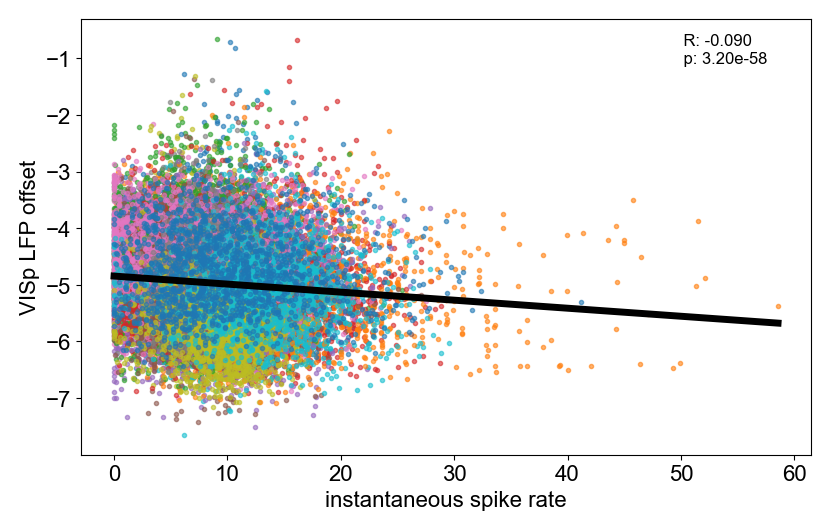

In [112]:
plot_linregress(vis_df, 'inst_spike_rate', 'offset', group='session', singlereg=True, colors=[None]*100,
               x_label='instantaneous spike rate', y_label='VISp LFP offset',
               fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/vis_inst_v_off.png', legend=False, print_stats=True)

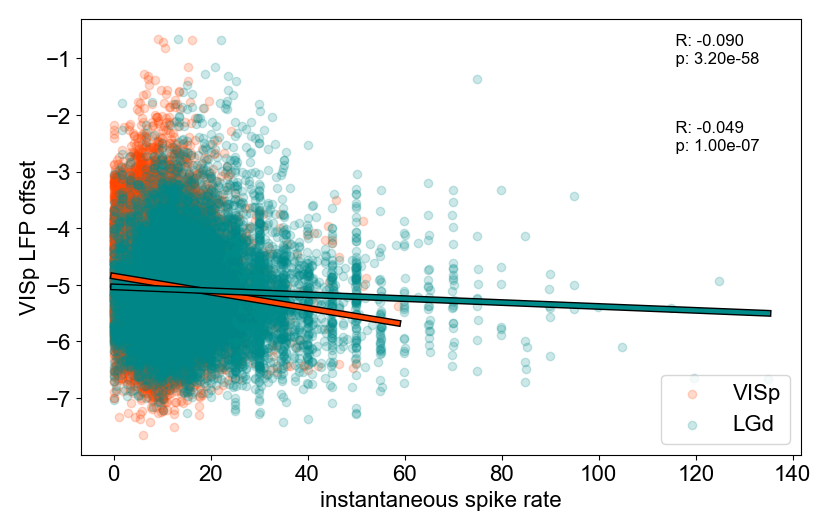

In [113]:
plot_linregress(params, 'inst_spike_rate', 'offset', scatter_alpha=0.2, colors=colors, 
                x_label='instantaneous spike rate', y_label='VISp LFP offset', legend=True, 
                fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/inst_v_off.png', 
                show=True, print_stats=True)

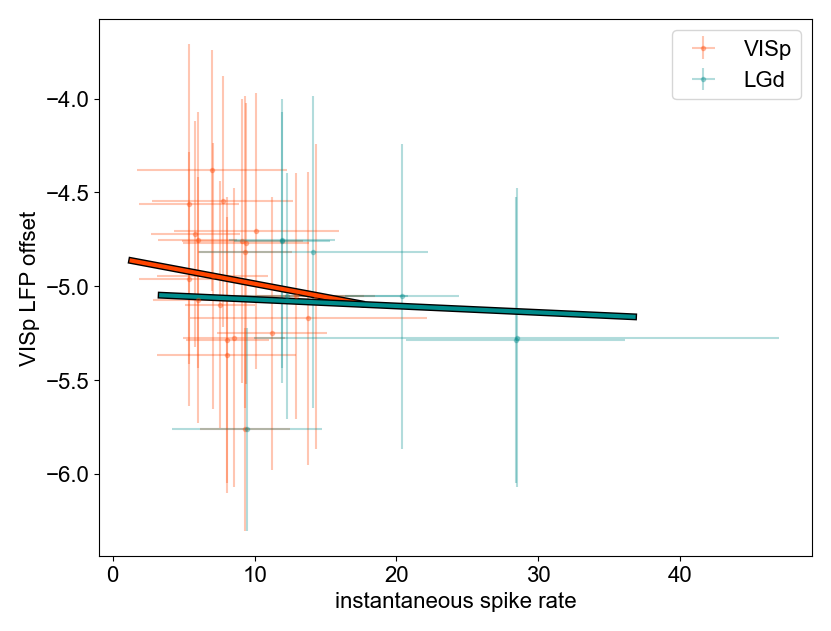

In [114]:
error_scatter_plot(params,'inst_spike_rate', 'offset','session', colors=colors, 
                   xlabel='instantaneous spike rate', ylabel='VISp LFP offset', 
                   fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/inst_v_off_error.png',
                   show=True)

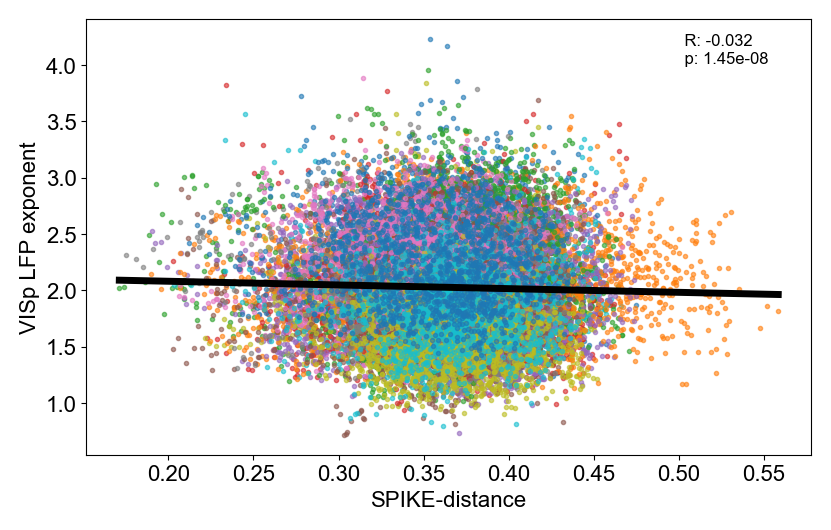

In [115]:
plot_linregress(vis_df, 'spike_distance', 'exponent', group='session', singlereg=True, colors=[None]*100,
               x_label='SPIKE-distance', y_label='VISp LFP exponent', legend=False, 
                fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/vis_spkdist_vs_exp.png',
                show=True, print_stats=True)

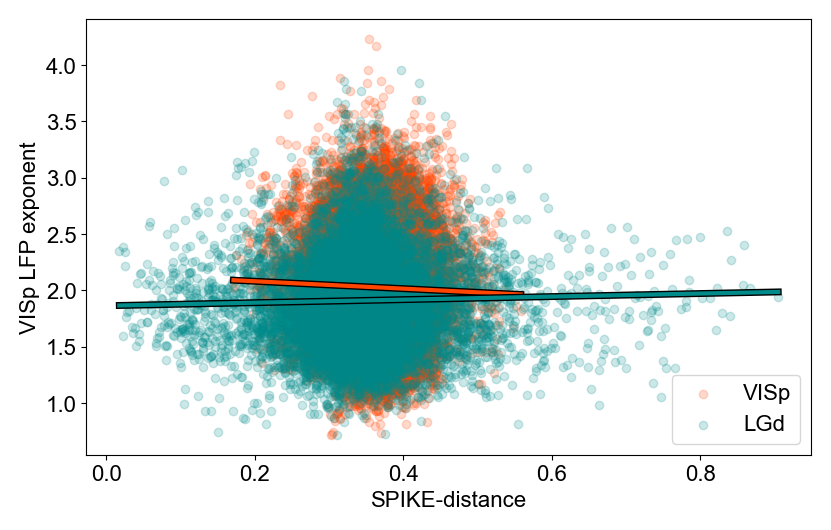

In [116]:
plot_linregress(params, 'spike_distance', 'exponent', scatter_alpha=0.2, colors=colors, 
                x_label='SPIKE-distance', y_label='VISp LFP exponent', legend=True, 
                fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/spkdist_vs_exp.png',
                show=True)

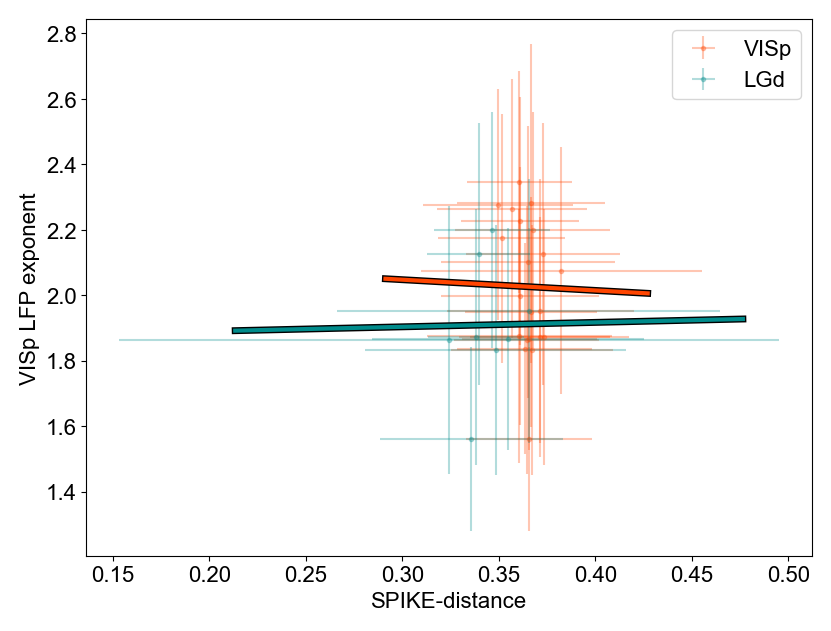

In [117]:
error_scatter_plot(params,'spike_distance', 'exponent','session', colors=colors, 
                   xlabel='SPIKE-distance', ylabel='VISp LFP exponent', 
                   fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/spkdist_vs_exp_error.png',
                   show=True)

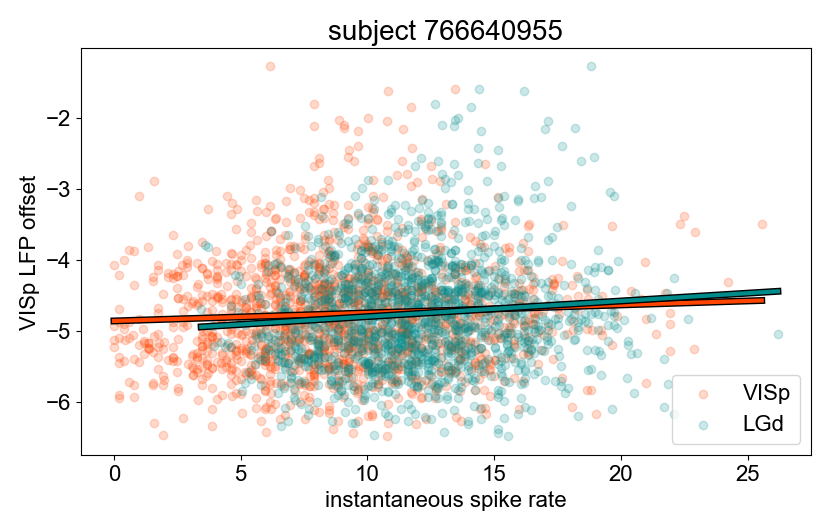

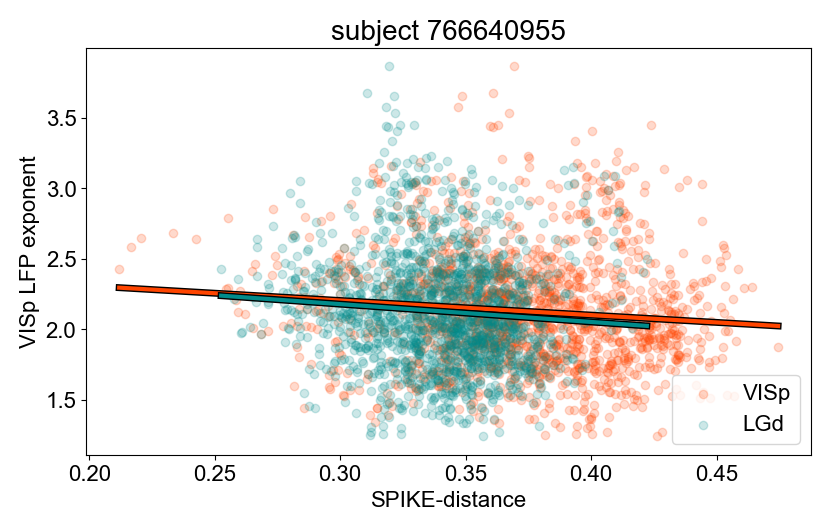

In [118]:
# plot an exemplary subject

subject = '766640955'

plot_linregress(params[params['session']==subject], 'inst_spike_rate', 'offset', scatter_alpha=0.2, colors=colors, 
                x_label='instantaneous spike rate', y_label='VISp LFP offset', legend=True, show=True, title='subject ' + subject,
               fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/inst_v_off_766640955.png')

plot_linregress(params[params['session']==subject], 'spike_distance', 'exponent', scatter_alpha=0.2, colors=colors, 
                x_label='SPIKE-distance', y_label='VISp LFP exponent', legend=True, show=True, title='subject ' + subject,
               fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/spkdist_vs_exp_766640955.png')

#### Pupil area v. LFP parameters

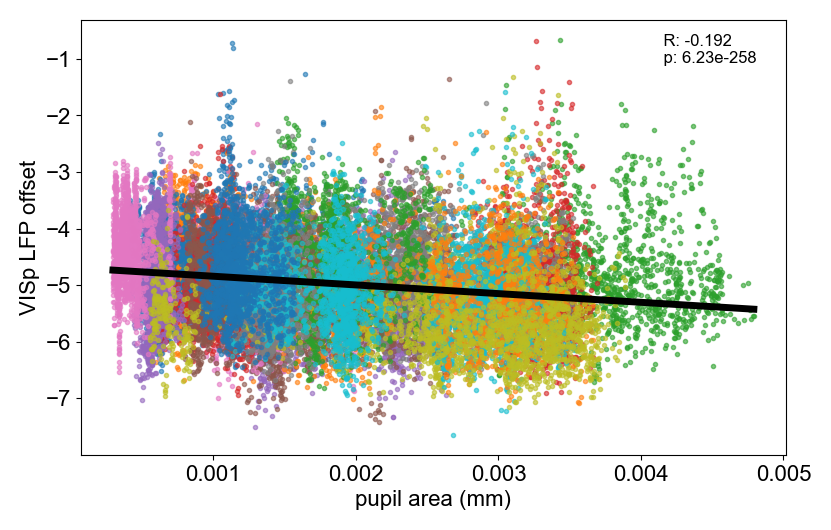

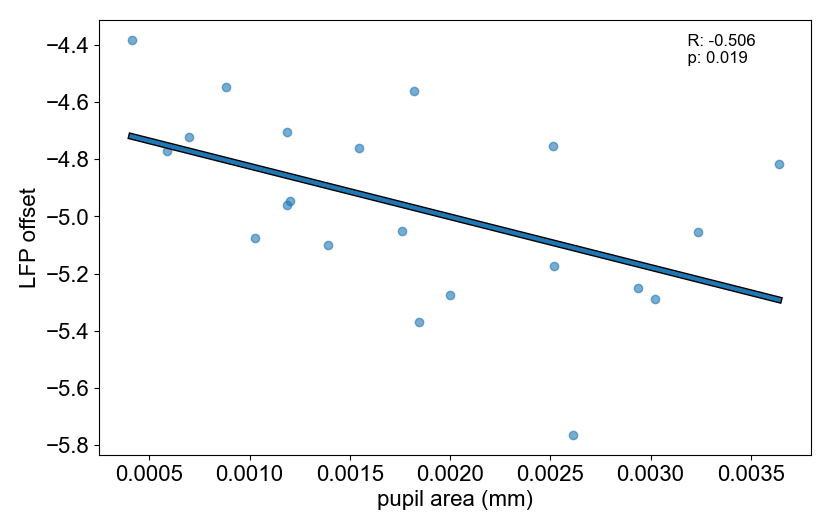

In [119]:
# Pupil area v LFP offset

# plot all data points
df = params.loc[params['brain_structure']=='VISp']
plot_linregress(df, 'avg_pupil_area', 'offset', group='session', singlereg=True, colors=[None]*100,
               x_label='pupil area (mm)', y_label='VISp LFP offset',
               fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/pupil_vs_off.png', legend=False, print_stats=True)
ax = plt.gca()

# plot session means
df_mean = df.drop(columns=['brain_structure']).groupby('session').mean().reset_index()
df_mean['brain_structure'] = 'VISp' # add back brain structure to prevent error in plot_linregress
plot_linregress(df_mean, 'avg_pupil_area', 'offset', x_label='pupil area (mm)', y_label='LFP offset',
               fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/pupil_vs_off_mean.png', legend=False, print_stats=True)
ax = plt.gca()

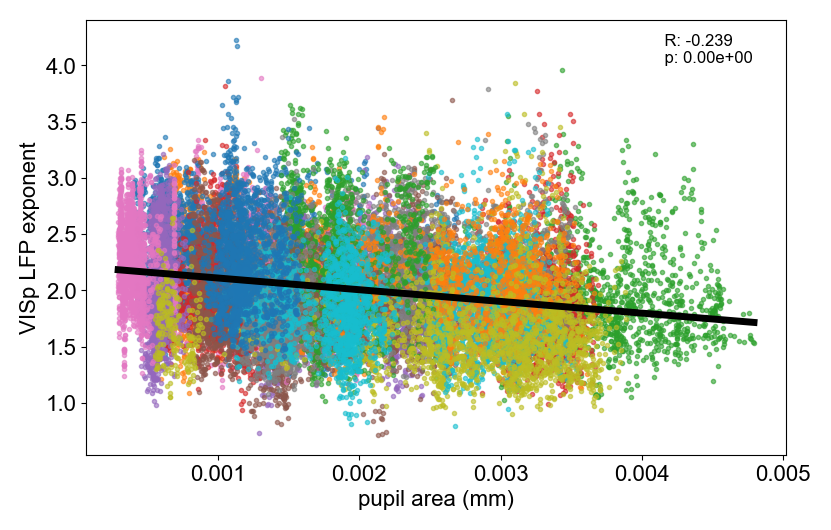

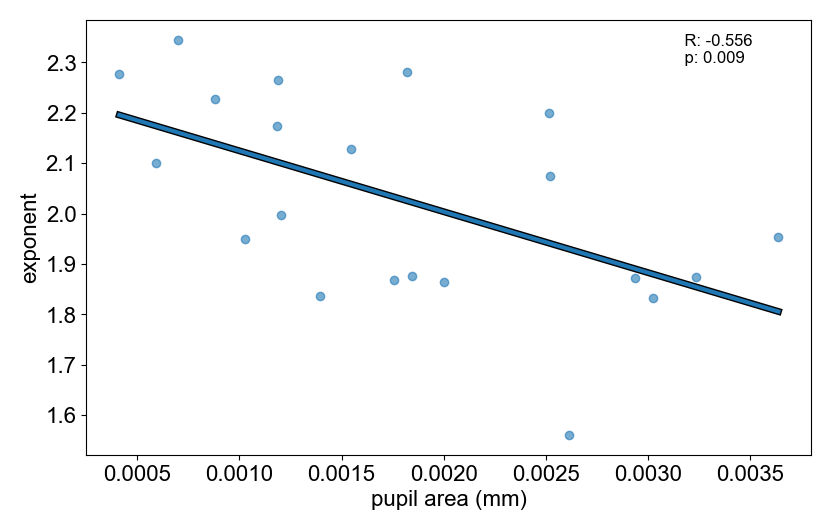

In [120]:
# Pupil area v LFP exponeny

# plot all data points
df = params.loc[params['brain_structure']=='VISp']
plot_linregress(df, 'avg_pupil_area', 'exponent', group='session', singlereg=True, colors=[None]*100,
               x_label='pupil area (mm)', y_label='VISp LFP exponent',
               fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/pupil_vs_exp.png', legend=False, print_stats=True)
ax = plt.gca()

# plot session means
df_mean = df.drop(columns=['brain_structure']).groupby('session').mean().reset_index()
df_mean['brain_structure'] = 'VISp' # add back brain structure to prevent error in plot_linregress
plot_linregress(df_mean, 'avg_pupil_area', 'exponent', x_label='pupil area (mm)', y_label='exponent',
               fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/pupil_vs_exp_mean.png', legend=False, print_stats=True)
ax = plt.gca()

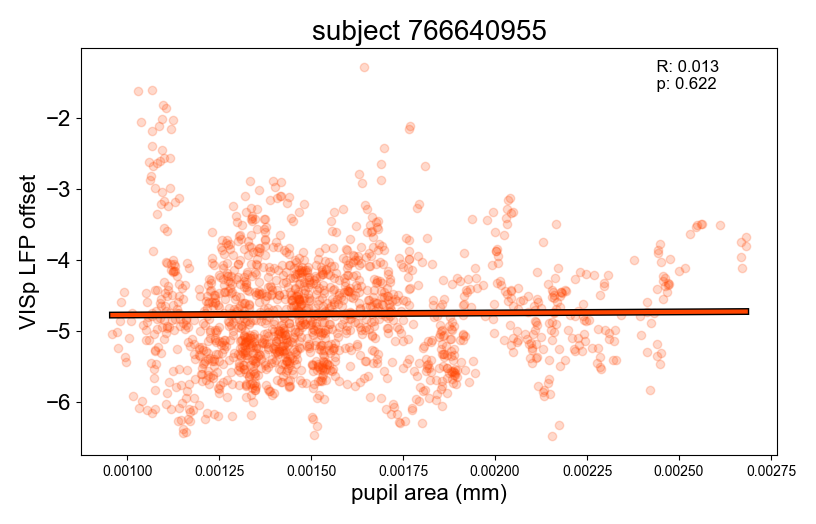

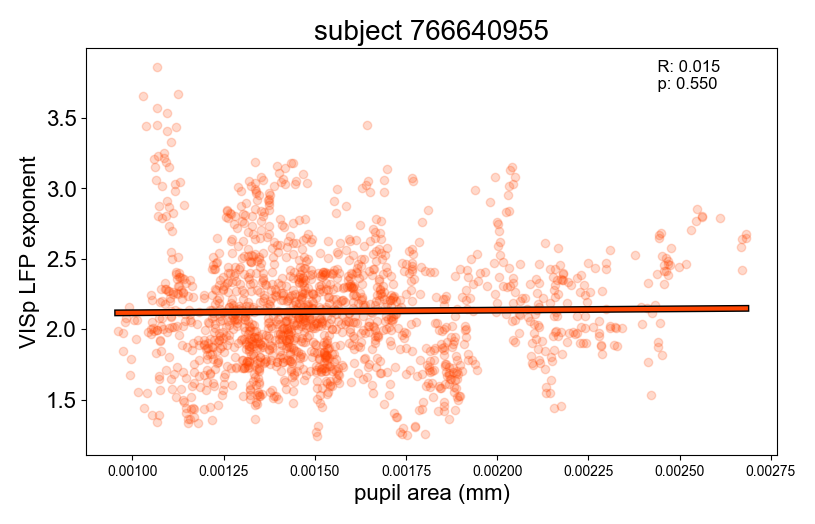

In [121]:
# plot an exemplary subject

subject = '766640955'

plot_linregress(df[df['session']==subject], 'avg_pupil_area', 'offset', scatter_alpha=0.2, colors=colors, 
                x_label='pupil area (mm)', y_label='VISp LFP offset', title='subject ' + subject,
               fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/pupil_vs_off_766640955.png', legend=False, print_stats=True)
plt.xticks(fontsize=10)

plot_linregress(df[df['session']==subject], 'avg_pupil_area', 'exponent', scatter_alpha=0.2, colors=colors, 
                x_label='pupil area (mm)', y_label='VISp LFP exponent', title='subject ' + subject,
               fname_out=f'{PROJECT_PATH}/figures/sfn_2023/panel_5/pupil_vs_exp_766640955.png', legend=False, print_stats=True)
plt.xticks(fontsize=10);

#### Pupil area v. spike metrics

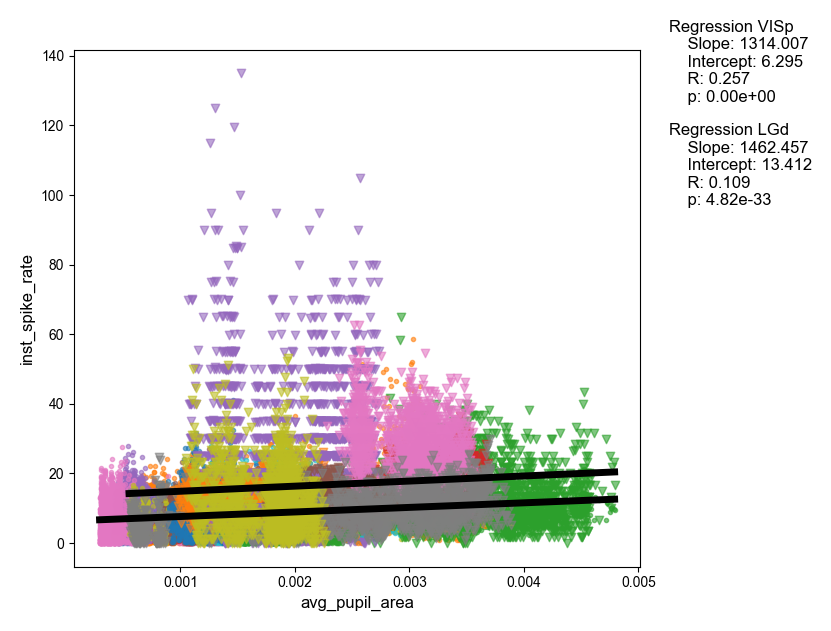

In [64]:
plot_linregress(params, 'avg_pupil_area', 'inst_spike_rate', group='session', show=True)

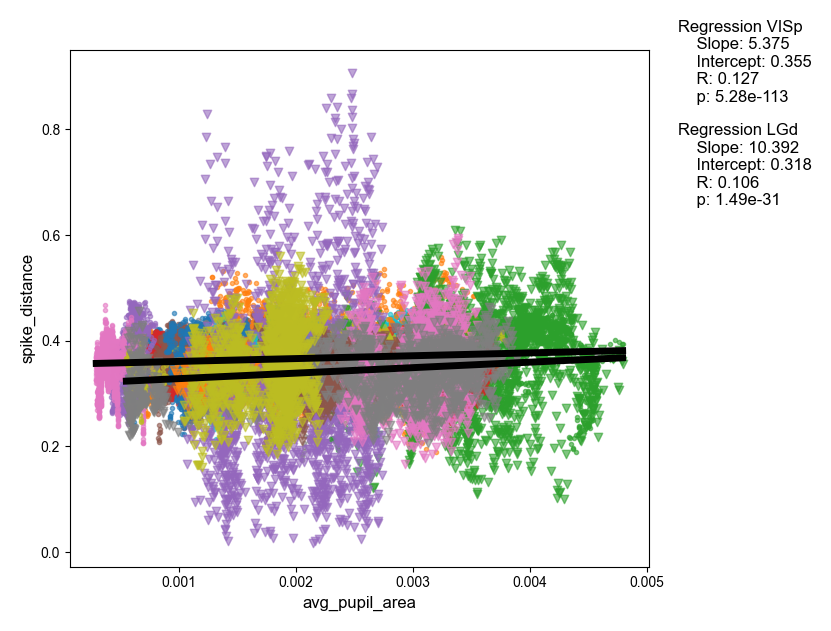

In [65]:
plot_linregress(params, 'avg_pupil_area', 'spike_distance', group='session', show=True)

### Parameter time series

In [75]:
help(plot_time_resolved_params)

Help on function plot_time_resolved_params in module allen_vc.plots:

plot_time_resolved_params(df, session, window, fs, title=None)
    Plot normalized time resolved aperiodic parameters.
    
    Parameters
    ----------
    df : pd.DataFrame
        dataframe containing lfp parameter data.
    session: str
        session from which to draw data.
    window: tuple of ints
        window indices corresponding to the window of data to plot.
    fs: int
        sampling frequency of data.
    title : str, optional
        title of the produced plot
    
    Returns
    -------
    None



In [9]:
params

,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,...,bw_2,cf_3,pw_3,bw_3,error,r_squared,inst_spike_rate,avg_pupil_area,spike_distance,brain_structure
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,...,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538,3.479088,0.002671,0.211924,VISp
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,...,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436,7.116836,0.002669,0.216571,VISp
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,...,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953,10.586037,0.002682,0.220487,VISp
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,...,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293,11.181677,0.002681,0.233542,VISp
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,...,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060,14.245542,0.002670,0.242386,VISp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31495,839068429,1,1495,-4.433972,596.401689,2.228863,7.322365,1.550040,3.796190,57.601872,...,3.434235,125.322853,1.242844,9.274708,0.329753,0.712398,24.499801,0.001961,0.256428,LGd
31496,839068429,1,1496,-5.154099,63.230997,2.004498,7.727685,1.434255,3.955395,56.844957,...,3.523543,123.675665,1.256478,9.193623,0.331126,0.745322,28.920941,0.001911,0.267220,LGd
31497,839068429,1,1497,-4.445894,350.735470,2.197408,7.232220,1.427688,4.029261,61.290384,...,7.415620,155.801234,1.209572,9.813020,0.332672,0.722443,37.752019,0.001839,0.244197,LGd
31498,839068429,1,1498,-4.369008,1746.366179,2.240819,7.077678,1.469906,3.756089,72.886946,...,8.841203,157.037145,1.137270,20.000000,0.321207,0.742624,35.507176,0.001828,0.247345,LGd


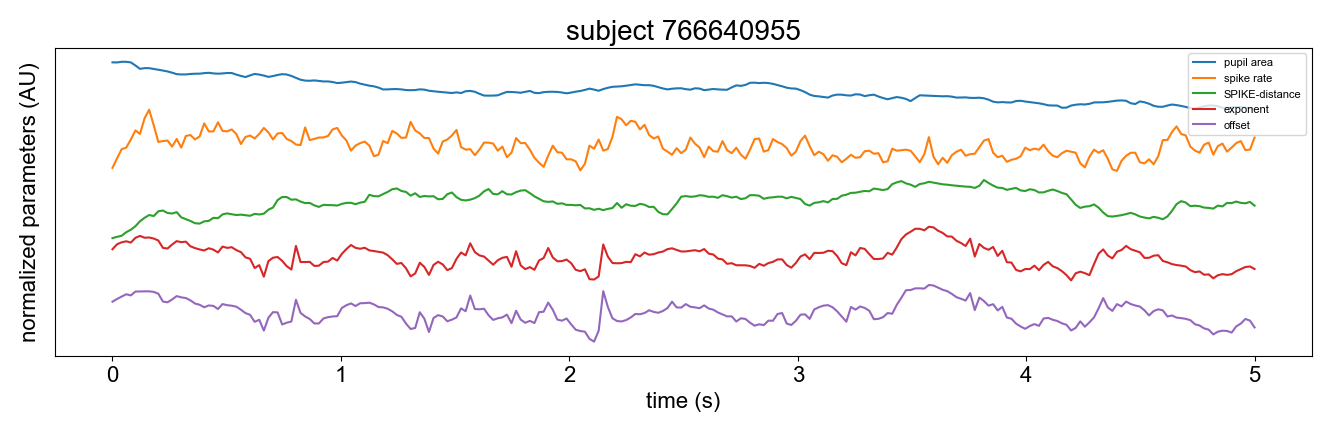

In [124]:
plot_time_resolved_params(params[params['brain_structure']=='VISp'], '766640955', (0,250), 
                          50, xlabel='time (s)', 
                          labels=['pupil area', 'spike rate', 'SPIKE-distance', 'exponent', 'offset'],
                          fname_out='G:/Shared drives/visual_encoding/figures/sfn_2023/panel_5/param_evolve.png', 
                          ylabel='normalized parameters (AU)');

### Statistics

In [ ]:
# linear mixed effect model

In [12]:
def create_long_region_df(df, suffix_metrics, merge_on):
    """Create long-format dataframe for plotting. Combine metrics for each region.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing metrics for each region.
    suffix_metrics : list
        List of metrics with different values for each region. 
        These will be appended with the region name.
    merge_on : str
        Column name to merge on (in addition to 'session' and 'epoch_idx').

    Returns
    -------
    df : pd.DataFrame
        Long-format dataframe.
    """

    v = df.loc[df['brain_structure'] == 'VISp']
    metrics = ['session', 'epoch_idx', merge_on] + suffix_metrics
    l = df.loc[df['brain_structure'] == 'LGd', metrics]
    df = v.merge(l, on=['session', 'epoch_idx', merge_on], suffixes=('_VISp', '_LGd'))
        
    return df

In [13]:
long_params = create_long_region_df(params, metrics, 'window_idx')

In [16]:
long_params.columns

Index(['session', 'epoch_idx', 'window_idx', 'offset', 'knee', 'exponent',
       'cf_0', 'pw_0', 'bw_0', 'cf_1', 'pw_1', 'bw_1', 'cf_2', 'pw_2', 'bw_2',
       'cf_3', 'pw_3', 'bw_3', 'error', 'r_squared', 'inst_spike_rate_VISp',
       'avg_pupil_area', 'spike_distance_VISp', 'brain_structure',
       'inst_spike_rate_LGd', 'spike_distance_LGd'],
      dtype='object')

In [17]:
# pupil area v. VISp instantaneous spike rate

mixedLM(long_params, 'inst_spike_rate_VISp', ['avg_pupil_area'], 'session')

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: inst_spike_rate_VISp
No. Observations: 12000   Method:             REML                
No. Groups:       8       Scale:              13.4304             
Min. group size:  1500    Log-Likelihood:     -32642.3657         
Max. group size:  1500    Converged:          Yes                 
Mean group size:  1500.0                                          
-------------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-------------------------------------------------------------------
avg_pupil_area   753.088    69.502  10.835  0.000  616.866  889.309
Group Var         66.483     9.005                                 



In [18]:
# offset

mixedLM(long_params, 'offset', ['inst_spike_rate_VISp', 'inst_spike_rate_LGd', 'spike_distance_VISp', 'spike_distance_LGd', 'avg_pupil_area'], 'session')

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   offset     
No. Observations:    12000     Method:               REML       
No. Groups:          8         Scale:                0.5403     
Min. group size:     1500      Log-Likelihood:       -13386.0116
Max. group size:     1500      Converged:            Yes        
Mean group size:     1500.0                                     
----------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
inst_spike_rate_VISp -0.011    0.002 -5.961 0.000  -0.015 -0.007
inst_spike_rate_LGd   0.000    0.001  0.584 0.559  -0.001  0.002
spike_distance_VISp  -0.011    0.171 -0.065 0.948  -0.347  0.324
spike_distance_LGd    0.098    0.084  1.168 0.243  -0.066  0.263
avg_pupil_area       -1.657   14.301 -0.116 0.908 -29.686 26.371
Group Var            24.018   15.548   

In [19]:
# exponent 

mixedLM(long_params, 'exponent', ['inst_spike_rate_VISp', 'inst_spike_rate_LGd', 'spike_distance_VISp', 'spike_distance_LGd', 'avg_pupil_area'], 'session')

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   exponent  
No. Observations:     12000     Method:               REML      
No. Groups:           8         Scale:                0.1385    
Min. group size:      1500      Log-Likelihood:       -5220.7864
Max. group size:      1500      Converged:            Yes       
Mean group size:      1500.0                                    
----------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
inst_spike_rate_VISp -0.008    0.001 -8.035 0.000  -0.009 -0.006
inst_spike_rate_LGd   0.000    0.000  0.485 0.628  -0.001  0.001
spike_distance_VISp   0.039    0.087  0.453 0.651  -0.131  0.209
spike_distance_LGd    0.058    0.043  1.353 0.176  -0.026  0.141
avg_pupil_area        1.427    7.241  0.197 0.844 -12.765 15.620
Group Var             3.553    4.484   